In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torch.nn import init
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
import math
import time

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline
use_cuda = torch.cuda.is_available()
# Load in data
data_string = 'lorAtt_10'
with open('lorAttData/%s.pickle' % (data_string), 'rb') as f: #Eventually take the file name as an argument
    data = pickle.load(f)
    
# Partition Data into Training, Validation, and Test sets (80/10/10)
random.seed(12345) # Comment out to get a different split every time
random.shuffle(data)
training = data[:(len(data)/10 * 8)]
val = data[(len(data)/10 * 8):(len(data)/10 * 9)]
test = data[(len(data)/10 * 9):]
print(len(data), len(training), len(val), len(test))

(10000, 8000, 1000, 1000)


In [2]:
# Convert to torch Tensors
for i in range(len(training)):
    training[i] = torch.FloatTensor(training[i]).pin_memory()
for i in range(len(val)):
    val[i] = torch.FloatTensor(val[i]).pin_memory()
for i in range(len(test)):
    test[i] = torch.FloatTensor(test[i]).pin_memory()
print(training[0].size(), type(training[0]))

(torch.Size([10, 1, 3]), <class 'torch.FloatTensor'>)


In [3]:
# Define model
weight_std = 0.03 # Need to choose the set of std's
                 # Deep information Propagation paper uses sigma^2 = {1, 1.5, 2, 2.5, 3, 3.5, 4}
                 # simga_w^2 > 0.2 causes the model to diverge, so lets pick values under that: {0.03,0.06,0.09,0.12,0.15}
                 # Also uses sigma_bias^2 = 0.05
weight_mean = 0.0
bias_mean = 0.0
bias_std = math.sqrt(0.05)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        #self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2h = nn.DataParallel(self.i2h)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.activation = nn.Tanh()
        
        for m in self.modules():
                if isinstance(m, torch.nn.Linear):
                    m.weight.data.normal_(weight_mean, weight_std)
                    m.bias.data.normal_(bias_mean, bias_std)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        combined = self.activation(combined)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size)) # if use_cuda else Variable(torch.zeros(1,self.hidden_size))
    
hidden_features = 128
n_dim = training[0].size()[2]

encoderRNN = RNN(n_dim, hidden_features, n_dim)
decoderRNN = RNN(n_dim, hidden_features, n_dim)

# encoderRNN = encoderRNN.cuda() #if use_cuda
# decoderRNN = decoderRNN.cuda() #if use_cuda
print(encoderRNN, decoderRNN)

(RNN (
  (i2h): Linear (131 -> 128)
  (i2o): Linear (131 -> 3)
  (activation): Tanh ()
), RNN (
  (i2h): Linear (131 -> 128)
  (i2o): Linear (131 -> 3)
  (activation): Tanh ()
))


In [4]:
# Define Loss function and learning rate and size of input sequence
criterion = nn.MSELoss(size_average = True) # cuda
learning_rate = 0.05
input_sequence_length = 9
encoder_optimizer = optim.SGD(encoderRNN.parameters(), lr = learning_rate)
decoder_optimizer = optim.SGD(decoderRNN.parameters(), lr = learning_rate)
batch_size = 4

def train(input_batch):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    for c in range(batch_size):
        input_traj = input_batch[c]
        hidden = encoderRNN.initHidden()
        input_traj = Variable(input_traj) # if use_cuda else Variable(input_circle)


        output_sequence_length = input_traj.size()[0] - input_sequence_length

        encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) #if use_cuda else encoderOutput
        decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim)) #if use_cuda else decoderOutput

        # Run the training sequence into the encoder
        for i in range(input_sequence_length):
            encoderOutput[i], hidden = encoderRNN(input_traj[i], hidden)

        # Now the last hidden state of the encoder is the first hidden state of the decoder.
        # For now, let's have the first input be the origin
        for i in range(output_sequence_length):
            if (i == 0):
                dummyState = Variable(torch.zeros(1,n_dim)) # if use_cuda else Variable(torch.zeros(1,n_dim))
                decoderOutput[i], hidden = decoderRNN(dummyState, hidden)
            else:
                decoderOutput[i], hidden = decoderRNN(decoderOutput[i-1], hidden)

        # Loss is calculated only on the decoder output
        loss += criterion(decoderOutput, input_traj[-(output_sequence_length):]) #.cuda())
        
    loss /= batch_size
    loss.backward()
    # Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0]

# Function for evaluating on validation and test sets
def evaluate(input_traj):
    hidden = encoderRNN.initHidden()
    input_traj = Variable(input_traj) # if use_cuda else Variable(circle)    

    output_sequence_length = input_traj.size()[0] - input_sequence_length
    
    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) #if use_cuda else encoderOutput
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim)) #if use_cuda else decoderOutput
    
    # Run the point sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden = encoderRNN(input_traj[i], hidden)
    
    # Now the last hidden state of the encoder is the first hidden state of the decoder. (whats the input to the first)
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) # if use_cuda else Variable(torch.zeros(1,n_dim))
            decoderOutput[i], hidden = decoderRNN(dummyState, hidden)
        else:
            decoderOutput[i], hidden = decoderRNN(decoderOutput[i-1], hidden)
    
    loss = criterion(decoderOutput, input_traj[-(output_sequence_length):]) #.cuda())
    return decoderOutput, loss.data[0]

Finished epoch [1 / 25]  with training loss 0.0149 and validation loss 0.003301
0m 24s
Finished epoch [2 / 25]  with training loss 0.002642 and validation loss 0.001704
0m 48s
Finished epoch [3 / 25]  with training loss 0.001333 and validation loss 0.001088
1m 12s
Finished epoch [4 / 25]  with training loss 0.001115 and validation loss 0.0009863
1m 36s
Progress was 3095.703
Finished epoch [5 / 25]  with training loss 0.001026 and validation loss 0.0009093
2m 1s
Progress was 483.141
Finished epoch [6 / 25]  with training loss 0.0009534 and validation loss 0.0008433
2m 25s
Progress was 198.869
Finished epoch [7 / 25]  with training loss 0.0008866 and validation loss 0.00078
2m 49s
Progress was 171.983
Finished epoch [8 / 25]  with training loss 0.0008192 and validation loss 0.0007141
3m 13s
Progress was 185.637
Finished epoch [9 / 25]  with training loss 0.0007478 and validation loss 0.0006435
3m 38s
Progress was 211.722
Finished epoch [10 / 25]  with training loss 0.0006735 and validati

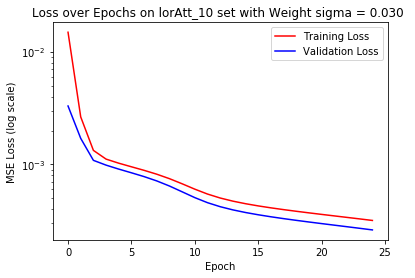

In [5]:
# Now, we are ready to train the model. Define some functions to help with plotting:
import copy

n_epochs = 25
current_loss_train = 0
current_loss_val = 0
all_losses_train = []
all_losses_val = []

# Keep track of losses from plotting

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m,s)

start = time.time()
for ep in range(n_epochs):
    n_batches = len(training)/batch_size
    for i in range(n_batches):
        loss =  train(training[i*batch_size:((i+1)*batch_size)])
        current_loss_train += loss/n_batches
    if math.isnan(current_loss_train):
        print("Stopped because loss exploded to NaN and will not converge")
        break

    for c in range(len(val)):
        pts, loss = evaluate(val[c])
        current_loss_val += loss/len(val)
    #Early Stopping

    # Method 2: Stop if Generalization Loss > 10% (see Automatic Early Stopping Using Cross Validation: Quantifying the Criteria by
    # Lutz Prechelt)
#     if ((ep != 0)):
#         if (current_loss_val/len(val) <= min(all_losses_val)):
#             print("New min at epoch %d" %(ep+1))
#             bestEncoder = copy.deepcopy(encoderRNN)
#             bestDecoder = copy.deepcopy(decoderRNN)
#         gLoss = current_loss_val/len(val) * (1/min(all_losses_val)) * 100 - 100
#         print("Generalization Loss at Epoch %d is %.3g" % (ep + 1, gLoss))
#         if (gLoss > earlyStoppingCriteria):
#             print("Stopping Early on epoch %g" % (ep+1))
#             print("Validation loss was %.4g" % (current_loss_val/len(val)))
#             encoderRNN = bestEncoder
#             decoderRNN = bestDecoder
#             break

        
        
    all_losses_train.append(current_loss_train)
    current_loss_train = 0
    all_losses_val.append(current_loss_val)
    current_loss_val = 0
    # Method 3: Stop if Progress < 0.5
    strip_length = 5
    if ((ep >= 4)):
        last_strip = all_losses_train[-strip_length:]
        progress = (np.mean(last_strip)/min(last_strip) - 1) * 1000
        print("Progress was %.3f" % progress)
        
    print("Finished epoch [%d / %d]  with training loss %.4g and validation loss %.4g" % (ep + 1, n_epochs,
                                                                                         all_losses_train[ep],
                                                                                          all_losses_val[ep]) )
    print(timeSince(start))
    if (ep >= 4) and progress < 50:
        print("Stopping early on epoch %d" % (ep + 1))
        print("Progress was %.3f" % (progress))
        break




plt.plot(all_losses_train, 'r', label="Training Loss")
plt.plot(all_losses_val, 'b', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.yscale('log')
plt.title('Loss over Epochs on %s set with Weight sigma = %.3f ' % (data_string, weight_std))
plt.legend()
#plt.savefig('circlePlots/loss_data_%s_wsd2_%.3f.png' % (data_string, math.pow(weight_std,2)))
plt.show()

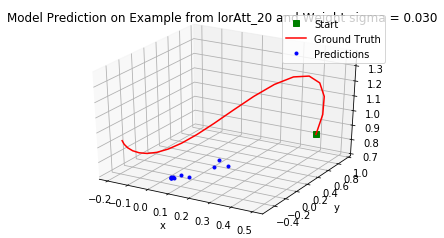

In [22]:
from mpl_toolkits.mplot3d import Axes3D
testTraj = test[random.randint(0,len(test))]
start_traj = testTraj.cpu().numpy()
points, loss = evaluate(testTraj)
end_traj = points.data.numpy()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(start_traj[0:1,0,0], start_traj[0:1,0,1], start_traj[0:1,0,2], 'gs', label='Start')
ax.plot(start_traj[:,0,0], start_traj[:,0,1], start_traj[:,0,2], 'r', label='Ground Truth')
ax.plot(end_traj[:,0,0], end_traj[:,0,1], end_traj[:,0,2], 'b.', label='Predictions')
# plt.plot(start_traj[:,0,0], start_traj[:,0,1], 'rs', label='Target Points')
# plt.plot(end_circle[:,0,0], end_circle[:,0,1], 'b.', label='Predicted Points')
plt.legend()
plt.title("Model Prediction on Example from %s and Weight sigma = %.3f" %(data_string, weight_std))
plt.xlabel('x')
plt.ylabel('y')
#plt.axes().set_aspect('equal', 'datalim')
#plt.savefig('circlePlots/vis_data_%s_wsd2_%.3f.png' % (data_string, math.pow(weight_std,2))
plt.show()         

In [ ]:
# Store the model somewhere
#torch.save(encoderRNN.state_dict(), 'circleModel/%s_encoder_wsd2_%.3f' % (data_string,  math.pow(weight_std,2))
#torch.save(decoderRNN.state_dict(), 'circleModel/%s_decoder_wsd2_%.3f' % (data_string,  math.pow(weight_std,2))

0.169403


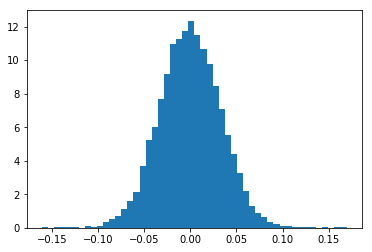

0.0806263


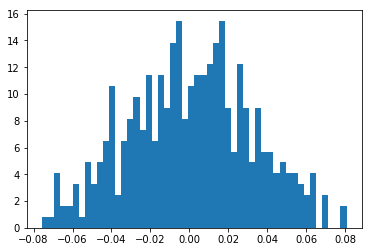

In [6]:
for m in encoderRNN.modules():
    if isinstance(m, torch.nn.Linear):
        temp = m.weight.data.numpy()
        print(np.amax(temp))
#         temp = temp/np.amax(temp)
        temp = temp.reshape(temp.size,1)
        n, bins, patches = plt.hist(temp, 50, normed = 1)
        plt.show()        